In [3]:
# import os
# import matplotlib.pyplot as plt
# os.environ.setdefault("DJANGO_SETTINGS_MODULE", "resume_scanner.settings")
# os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    
# import django
# django.setup()

# from django.core.management import call_command
import functools
import json
from nltk.corpus import stopwords
import pandas as pd
import pickle
import re
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [4]:
# unified is segregated scan/swipe vectorizers with job/applicant columns merged into one feature
unified = pd.read_pickle('unified_col_seg.pkl')
# separate is segregated scan/swipe vectorizers with job/applicant columns separate
separate = pd.read_pickle('seg_scan_swipe.pkl')
# combined is unsegregated scan/swipe vectorizers with job/applicant columns separate
combined_df = pd.read_pickle('combined.pkl')
# combined_unified is unsegregated scan/swipe vectorizers with job/applicant columns merged into one feature
combined_unified_df = pd.read_pickle('unified_combined.pkl')
# combined_df['like'] = combined_df['like'].map({True: 1, False: 0})

In [4]:
accuracies = []
precisions = []
recalls = []
predict_rights = []
best_models = []

for j in range(5):
    print(j)
    for i in [unified, separate, combined_df, combined_unified_df]:
        df = i
        ## Only train on data that has outcome variables
        df_like_data = df[~df.like.isna()]

        X_train, X_test, y_train, y_test = train_test_split(
            df_like_data.drop(columns=['like']), df_like_data.like, test_size=0.3
        )

        rf_param_grid = {
            'max_depth': [6, 8, 10, 12, 15],
            'max_features': [0.25, 0.5, 0.75, None],
            'n_estimators': [50, 75, 100]
        }

        gscv = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
        gscv.fit(X_train, y_train)
        best_rf = gscv.best_estimator_

        X_train, X_test, y_train, y_test = train_test_split(
            df_like_data.drop(columns=['like']), df_like_data.like, test_size=0.3
        )

        train_rf_pred = best_rf.predict(X_train)
        test_rf_pred = best_rf.predict(X_test)

        ## Identify data without outcome variables
        df_no_like_data = df[df.like.isna()]

        ## Build lists containing results
        if i is unified:
            accuracies.append(
                {
                    'train': [np.round(accuracy_score(y_train, train_rf_pred), 3)],
                    'test': [np.round(accuracy_score(y_test, test_rf_pred), 3)]
                }
            )
            precisions.append(
                {
                    'train': [np.round(precision_score(y_train, train_rf_pred), 3)],
                    'test': [np.round(precision_score(y_test, test_rf_pred), 3)]
                }
            )
            recalls.append(
                {
                    'train': [np.round(recall_score(y_train, train_rf_pred), 3)],
                    'test': [np.round(recall_score(y_test, test_rf_pred), 3)]
                }
            )
            predict_rights.append([
                np.round((len(list(filter(
                    lambda i: i, best_rf.predict(df_no_like_data.drop(columns=['like']))
                )))/df_no_like_data.shape[0]), 3)
            ])
            best_models.append([best_rf])
        else:
            accuracies[-1]['train'].append(np.round(accuracy_score(y_train, train_rf_pred), 3))
            accuracies[-1]['test'].append(np.round(accuracy_score(y_test, test_rf_pred), 3))
            precisions[-1]['train'].append(np.round(precision_score(y_train, train_rf_pred), 3))
            precisions[-1]['test'].append(np.round(precision_score(y_test, test_rf_pred), 3))
            recalls[-1]['train'].append(np.round(recall_score(y_train, train_rf_pred), 3))
            recalls[-1]['test'].append(np.round(recall_score(y_test, test_rf_pred), 3))
            predict_rights[-1].append(np.round((len(list(filter(
                lambda i: i, best_rf.predict(df_no_like_data.drop(columns=['like']))
            )))/df_no_like_data.shape[0]), 3))
            best_models[-1].append(best_rf)

0
1
2
3
4


In [5]:
print('#######ACCURACY#######')
for i in accuracies:
    print(i)
print('#######PRECISION#######')
for i in precisions:
    print(i)
print('#######RECALL#######')
for i in recalls:
    print(i)
print('#######PREDICTED PROPORTIONS#######')
for i in predict_rights:
    print(i)
print('#######MODELS#######')
for i in best_models:
    print(i)

#######ACCURACY#######
{'train': [0.766, 0.825, 0.803, 0.78], 'test': [0.782, 0.785, 0.77, 0.792]}
{'train': [0.73, 0.78, 0.778, 0.769], 'test': [0.704, 0.758, 0.812, 0.78]}
{'train': [0.728, 0.751, 0.807, 0.81], 'test': [0.76, 0.773, 0.809, 0.829]}
{'train': [0.714, 0.756, 0.757, 0.73], 'test': [0.731, 0.792, 0.787, 0.731]}
{'train': [0.706, 0.792, 0.804, 0.749], 'test': [0.743, 0.804, 0.807, 0.756]}
#######PRECISION#######
{'train': [0.815, 0.884, 0.816, 0.862], 'test': [0.881, 0.744, 0.789, 0.778]}
{'train': [0.852, 0.817, 0.829, 0.819], 'test': [0.805, 0.76, 0.888, 0.792]}
{'train': [0.823, 0.758, 0.832, 0.811], 'test': [0.927, 0.727, 0.785, 0.833]}
{'train': [0.848, 0.768, 0.787, 0.76], 'test': [0.711, 0.795, 0.841, 0.78]}
{'train': [0.802, 0.791, 0.837, 0.844], 'test': [0.816, 0.823, 0.909, 0.811]}
#######RECALL#######
{'train': [0.406, 0.574, 0.53, 0.448], 'test': [0.421, 0.508, 0.486, 0.485]}
{'train': [0.235, 0.465, 0.445, 0.435], 'test': [0.226, 0.413, 0.511, 0.432]}
{'train'

In [6]:
## After inspection, find and save our best model!
best_rf_replace_10 = best_models[2][3]
print(best_rf_replace_10)
pickle.dump(best_rf_replace_10, open('best_rf', 'wb'))

RandomForestClassifier(max_depth=12, max_features=0.25, n_estimators=75)

In [57]:
## Flatten accuracy/precision/recall lists to visualize them below
test_acc = functools.reduce(lambda a, b: a + b, [i['test'] for i in accuracies])
test_prec = functools.reduce(lambda a, b: a + b, [i['test'] for i in precisions])
test_rec = functools.reduce(lambda a, b: a + b, [i['test'] for i in recalls])

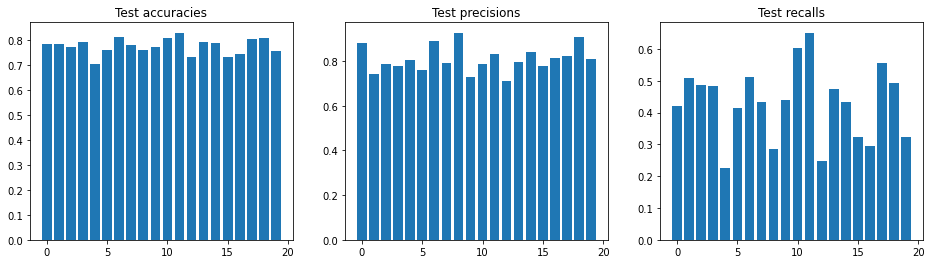

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
x_range = range(20)
axs[0].bar(x_range, test_acc)
axs[0].set_title('Test accuracies')
axs[1].bar(x_range, test_prec)
axs[1].set_title('Test precisions')
axs[2].bar(x_range, test_rec)
axs[2].set_title('Test recalls')
plt.show()